In this notebook we'll examine some A/B testing results from both a frequentist and bayesian perspective. We'll look to examine whether the variant produced a higher revenue per visit or per purchase.

In [1]:
!pip install pymc -q

In [2]:
import arviz
import matplotlib.pyplot as plt
import numpy
import pandas
import plotly.express as px
import plotly.graph_objects as go
import pymc
import scipy.stats as stats

## Exploratory Analysis

Let's go ahead and look at the first few samples

In [3]:
df = pandas.read_csv("/kaggle/input/ab-test-data/AB_Test_Results.csv")
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


and get some general metadata about our columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


We have 10,000 entries with no missing values. Let's check to see if our users are all unique:

In [5]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

Looks like about ~3700 of our data samples are of repeated customers. Let's see if any of them participated in both groups:

In [6]:
df.groupby("USER_ID")["VARIANT_NAME"].nunique().value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

About 25% of our users saw both tests. Let's go ahead and remove these users.

In [7]:
duplicate_users = df.groupby("USER_ID")["VARIANT_NAME"].nunique() == 2
duplicate_users = duplicate_users[duplicate_users].index
df = df[~df["USER_ID"].isin(duplicate_users)]

Let's check to see if any of our users had an unusual amount of traffic

In [8]:
df["USER_ID"].value_counts().value_counts()

1    3664
2     976
3     122
4      18
5       2
6       1
Name: USER_ID, dtype: int64

Nothing looks unusual with the traffic numbers.

Let's go ahead and look at the revenue distribution for each group

In [9]:
px.box(df.loc[df["REVENUE"] > 0], x="REVENUE", color="VARIANT_NAME", labels=dict(VARIANT_NAME="Group"))

We have a prominent outlier with a revenue around 200 that could be a bulk order while the remaining samples look more reasonable. There are a variety of approaches for handling outliers, but let's assume for simplicity that the user was not part of our target population and remove them from our dataset.

In [10]:
df = df[df["REVENUE"] < 150]

## Statistical Analysis

### Standard Frequentist Metrics

There are various statistical tests to measure the significance of the difference between two populations, each with its own assumptions. Two common assumptions are that the samples are normally distributed (which looks unlikely in our case) and that the variances are similar. Let's go ahead and perform some calculations on our purchases to see if these assumptions are correct:

In [11]:
df.groupby("VARIANT_NAME").agg({
    "USER_ID": [
        ("Total", len),
        ("Unique", "nunique"),
    ],
    "REVENUE": [
        ("Purchases", lambda x: sum(x>0)),
        ("Purchase Fraction", lambda x: sum(x>0) / len(x)),
        ("Total Revenue", "sum"),
        ("Average Revenue", lambda x: numpy.mean(x[x>0])),
        ("STD Revenue", lambda x: numpy.std(x[x>0], ddof=1)),
        ("Shapiro-Wilk (p)", lambda x: stats.shapiro(x[x>0])[1]),
        ("D'Agostino-Pearson (p)", lambda x: stats.normaltest(x[x>0])[1]),
    ],
})

USER_ID          REVENUE                                  \
               Total Unique Purchases Purchase Fraction Total Revenue   
VARIANT_NAME                                                            
control         3025   2389        53          0.017521        274.55   
variant         3044   2393        43          0.014126        179.32   

                                                           \
             Average Revenue STD Revenue Shapiro-Wilk (p)   
VARIANT_NAME                                                
control             5.180189    5.942771     4.129961e-08   
variant             4.170233    4.932851     5.565098e-08   

                                     
             D'Agostino-Pearson (p)  
VARIANT_NAME                         
control                2.455830e-08  
variant                1.578531e-08

From both the Shapiro-Wilk and D'Agostino-Pearson tests we can reject the null hypothesis that that our revenue data is normally distributed.

We can test whether the variances are equal using the Levene test:

In [12]:
control = df.query("VARIANT_NAME == 'control'")
variant = df.query("VARIANT_NAME == 'variant'")
stats.levene(
    control["REVENUE"][control["REVENUE"] > 0], 
    variant["REVENUE"][variant["REVENUE"] > 0]
)

LeveneResult(statistic=0.7175741843558987, pvalue=0.3990923631774761)

Using a high confidence like 95% we can't reject the null hypothesis that the variances are the same.

Since the distributions are non-normal let's use the Mann-Whitney test to see if there is a difference in the median.

In [13]:
stats.mannwhitneyu(variant['REVENUE'], control['REVENUE'])

MannwhitneyuResult(statistic=4588312.0, pvalue=0.2859842308619548)

Applying it to the full dataset we get a p value of 0.29, so we can't reject the null hypothesis that there is no difference between the two medians.

In [14]:
stats.mannwhitneyu(variant.query("REVENUE > 0")['REVENUE'], control.query("REVENUE > 0")['REVENUE'])

MannwhitneyuResult(statistic=1030.0, pvalue=0.4218148352342157)

Applying it to just the purchases we get a p value of 0.42, so we can't reject the null hypothesis either.

### Bootstrapping

One means of estimating the distribution parameters is through bootstrapping. Let's go ahead and define a bootstrapping routine that will randomly sample from the variant and control datasets and calculate the mean revenue per purchase and visit for each bootstrap sample. Let's run it for 1000 iterations.

In [15]:
def bootstrap(size:int=1000):
    kwargs = {"frac": 1, "replace": True}

    output = pandas.DataFrame(columns=["mean_per_visit", "mean_per_purchase", "group"])
    for i in range(size):
        v = variant["REVENUE"].sample(random_state=13*i+17, **kwargs)
        c = control["REVENUE"].sample(random_state=17*i+13, **kwargs)
        
        summary = {
            "mean_per_visit": [x.mean() for x in (v,c)],
            "mean_per_purchase": [x[x>0].mean() for x in (v,c)],
            "group": ["variant", "control"]
        }
        summary = pandas.DataFrame(summary)
        output = pandas.concat((output, summary), ignore_index=True)
        
    return output

output = bootstrap()

Looking at the distributions the control group tends to generate a bit more revenue per purchase and visit than the variant group on average.

In [16]:
for c in output.columns[:-1]:
    fig = px.histogram(
        output,
        x=c,
        color="group",
        marginal="box",
        barmode="overlay",
        opacity=0.5
    ).update_layout(xaxis_title=f"Revenue ({c.replace('_', ' ').capitalize()})").show()

If we plot the 95% confidence interval for the mean offsets we'll see that zero falls within the range for both measures, so we are unable to reject the null hypothesis.

In [17]:
variant_bootstrap = output.query("group == 'variant'").drop(columns="group").reset_index(drop=True)
control_bootstrap = output.query("group == 'control'").drop(columns="group").reset_index(drop=True)

diff = variant_bootstrap - control_bootstrap

confidence = 0.95
clb = diff.quantile(1 - confidence)
cub = diff.quantile(confidence)

for c in output.columns[:-1]:
    fig = px.histogram(diff, x=c, marginal="box")
    for x in [clb, cub]:
        fig.add_vline(x[c])
    fig.update_layout(xaxis_title="Variant - Control Revenue Offset ({})".format(c.replace("_", " ").capitalize()))
    fig.show()

### Bayesian

Bayesian approaches are another means of estimating the distribution, but it requires specifying priors for each parameter.

One of our quantities is the probability of a purchase. While beta distributions are commonly used for the prior in such cases, let's make use of a truncated normal distribution bounded between 0 and 1 as it is a bit more intuitive to understand. 

For our revenue per purchase let's use a truncated normal for the mean and standard deviation and set a lower bound to zero and leave the upper bound as infinity.

In [18]:
group_idx, group_name = pandas.factorize(df["VARIANT_NAME"])

with pymc.Model(coords={"groups": group_name}) as model:

    # Priors
    p = pymc.TruncatedNormal(
        "p",
        mu=(df["REVENUE"] > 0).sum() / len(df), # p-value from data (over both groups)
        sigma=0.1,
        lower=0,
        upper=1,
        dims="groups"
    )
    
    mu = pymc.TruncatedNormal(
        "mu",
        mu=df.query("REVENUE > 0")["REVENUE"].mean(), # mu from dataset (over both groups)
        sigma=10,
        lower=0,
        dims="groups"
    )

    sigma = pymc.TruncatedNormal("sigma",
        mu=df.query("REVENUE > 0")["REVENUE"].std(ddof=1), # std from dataset (over both groups)
        sigma=10,
        lower=0,
        dims="groups"
    )
    
    # Probability fit
    pymc.Bernoulli(
        "p_obs",
        p=p[group_idx],
        observed=(df["REVENUE"] > 0).astype('float')
    )
    
    # Revenue fit per sale
    mask = df["REVENUE"] > 0
    y = pymc.Normal("y_obs", mu=mu[group_idx[mask]], sigma=sigma[group_idx[mask]], observed=df.loc[mask,"REVENUE"])

    # Extra quantities of interest
    mean_diff_visit = pymc.Deterministic("Variant - Control Revenue Offset (Mean per Visit)", mu[0]*p[0] - mu[1]*p[1])
    mean_diff_purchase = pymc.Deterministic("Variant - Control Revenue Offset (Mean per Purchase)", mu[0] - mu[1])

    # Run sampler
    trace = pymc.sample(1000, tune=1000)

If we plot our traces we'll see that the control group most likely has a bit higher probability of a purchase as well as a bit more revenue per purchase.

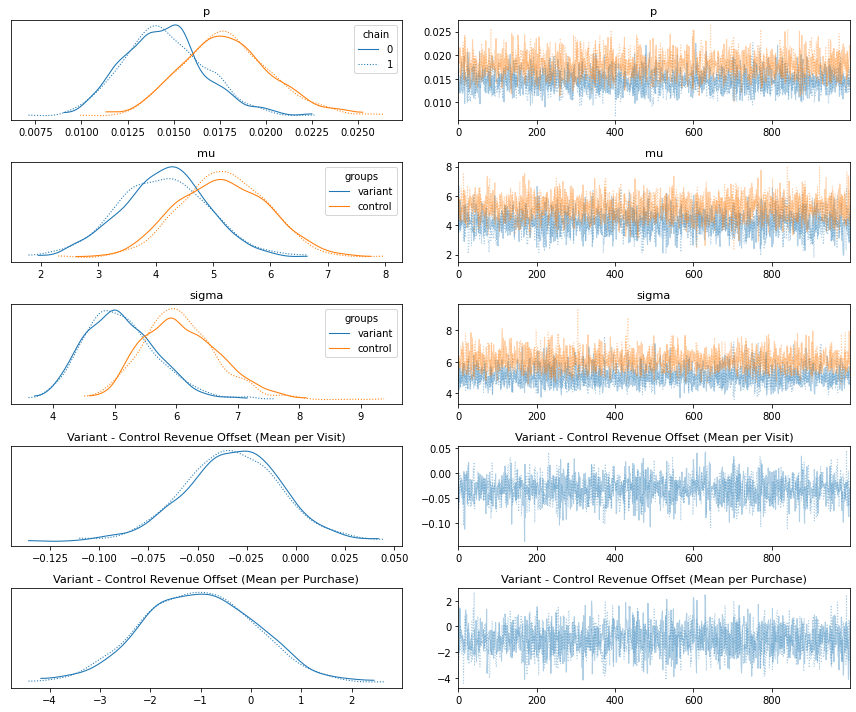

In [19]:
arviz.plot_trace(trace, legend=True);
plt.tight_layout()

Let's go ahead and plot the 95% confidence intervals

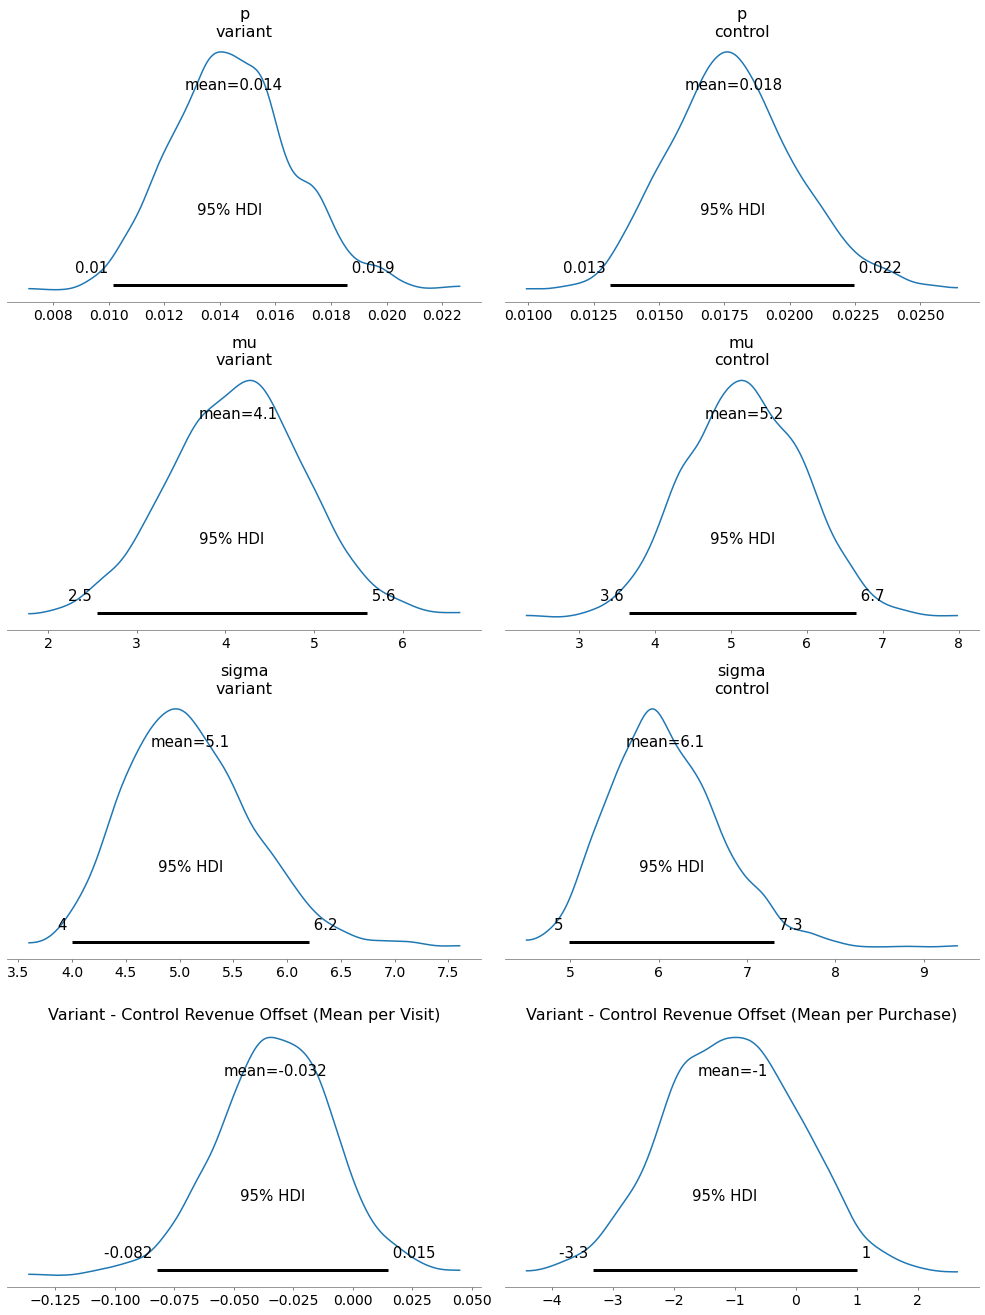

In [20]:
arviz.plot_posterior(trace, grid=(4,2), hdi_prob=0.95);
plt.tight_layout()

Our confidence intervals for both the mean offset in revenue per purchase and per visit include zero. It's more likely than not, though, that our control group performs a bit better than the variant.